In [1]:
# standard imports
import numpy as np
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# import codipack
import sys
sys.path.append("codiswig")
from codi import RealForward, RealReverse

In [3]:
# import geometry classes
from geometry.node import node
from geometry.cell import cell
from geometry.mesh import rot_sym_mesh
from problem.isentropic_navier_stokes import convection, diffusion, skalar_product, curl

# utility functions
from utilities.utilities import *
from utilities.pod import get_POD, get_activations

# Setting Custom Problem

In [4]:
# read su2 mesh file
meshio_mesh = meshio.read("./mesh_files/mesh_cylinder_quad.su2",file_format="su2")
# convert mesh into custom class exp_mesh
mesh = rot_sym_mesh(meshio_mesh)

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2


Initializing Mesh---------------------------------------------------------------
Mesh Initialization Successful!-------------------------------------------------


# Geometric Constants

In [5]:
# DEFINING CONSTANTS
n = mesh.n                  # number of nodes
N = mesh.N                  # number of cells
T = 220                     # number of snapshots
alpha = 1                   # inner product coefficient  # method for derivative computation
gamma = 1.4                 # isentropic coefficient -> material property
max_POD = 40                # maximum number of POD modes
mach = 0.6                  # mach number
sos = 340.29                # isentropic speed of sound
u_free = mach * sos         # freestream velocity
Re = 100                    # Reynolds number of freeflow
dt = 0.0001                 # simulation time step
include_avg = False         # include average flow in POD computation
nondim = False              # apply nondimensionalization to results
subsampling = 6             # subsampling for data
stabilization = "viscosity" # stabilization method for galerkin system
controlled = False          # activate controlled system
tau = 0                     # penalty term coefficient

# Data Preparation

In [6]:
# reading file data
data_dir  = "./flow_data/lam_cyl_comp_air/mach 0.6/"
data_dict = read_csv_data(data_dir,delay=0,subsampling=subsampling,max_size=T)

# geometric information
x = data_dict["x"][:,0] - 0.5
y = data_dict["y"][:,0]

# fluid velocity and mach number
u = np.divide(data_dict['Momentum_x'], data_dict['Density'])
v = np.divide(data_dict['Momentum_y'], data_dict['Density'])
a = data_dict['Mach']

# construct state based data
q = np.vstack([u,v,a])
T = q.shape[1]
q_avg = np.mean(q,1)
q_fluc = q - np.repeat(np.expand_dims(q_avg,1),T,axis=1)

# data for pod decomposition
if include_avg:
    pod_data = q
else:
    pod_data = q_fluc

### set scalar weights for multiplicative computation
# volume participations
volume_weight = mesh.volume_weights
# additional weight for speed of sound
mach_weight = (2 * alpha / (gamma - 1))
# construction of weights
inner_weight = np.concatenate([np.ones(n),np.ones(n),mach_weight*np.ones(n)]) * volume_weight

100%|██████████| 220/220 [01:21<00:00,  2.69it/s]


# POD Decomposition

In [7]:
[pod_modes, S] = get_POD(pod_data,inner_weight,20)
coeffs = get_activations(pod_data,pod_modes,inner_weight,20)
if nondim:
    coeffs /= u_free

In [8]:
# energy reconstruction threshold
epsilon = 0.99
acc = 0
num = 0
while acc < epsilon:
    num+=1
    acc = sum(S[:num])/sum(S)    
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(num))
if num % 2 == 1:
    num+=1

# manual value
num = 6

Number of eigenvectors necessary for thresholded reconstruction: 	4


In [9]:
# plot_activations(coeffs,8,dt=dt*subsampling)

# Control Data Input

In [10]:
control_dir  = "./flow_data/lam_cyl_comp_air/potVortex_0.6_1/"
control_dict = read_csv_data(control_dir,0,1,1)

u_con = np.divide(control_dict['Momentum_x'], control_dict['Density'])
v_con = np.divide(control_dict['Momentum_y'], control_dict['Density'])
a_con = control_dict['Mach']

# construct state based data
q_con = np.vstack([u_con,v_con,a_con]).squeeze()

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


# Control Function Method
Additional coefficients in Galerkin system

In [11]:
# Computation of Galerkin control terms
Lcon = diffusion(mesh,q_con)
Qcon = convection(mesh,q_con,q_con)
Qconavg_1 = convection(mesh,q_con,q_avg)
Qconavg_2 = convection(mesh,q_avg,q_con)

# initialize arrays
d1 = np.empty(num)
d2 = np.empty(num)
f = np.empty(num)
g = np.empty((num,num))
h = np.empty(num)

# compute temporary L and Q operators for projection
tmp_1 = np.empty((num,3*n))
tmp_2 = np.empty((num,3*n))
for i in tqdm(range(num)):
    tmp_1[i] = convection(mesh,q_con,pod_modes[:,i])
    tmp_2[i] = convection(mesh,pod_modes[:,i],q_con)

# compute finale coefficients
for k in range(num):
    d1[k] = skalar_product(Lcon,pod_modes[:,k],inner_weight)
    d2[k] = skalar_product(Qconavg_1 + Qconavg_2,pod_modes[:,k],inner_weight)
    f[k] = skalar_product(Qcon,pod_modes[:,k],inner_weight)
    h[k] = skalar_product(q_con,pod_modes[:,k],inner_weight)
    for i in range(num):
        g[k,i] = skalar_product(tmp_1[i] + tmp_2[i],pod_modes[:,k],inner_weight)

100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


# Galerkin Coefficients

In [12]:
# Galerkin system coefficients
# Computation of Galerkin system parameters
Qavg = convection(mesh,q_avg,q_avg)
Lavg = diffusion(mesh,q_avg)

# initialize arrays for parameters
b1 = np.empty(num)
b2 = np.empty(num)
L1 = np.empty((num,num))
L2 = np.empty((num,num))
Q_ = [np.empty((num,num,)) for x in range(num)]

# compute L and Q operators for projection
Q_tmp1 = np.empty((num,3*n))
Q_tmp2 = np.empty((num,3*n))
Q_tmp3 = np.empty((num,num,3*n))
L_tmp = np.empty((num,3*n))

for i in tqdm(range(num)):
    Q_tmp1[i] = convection(mesh,q_avg,pod_modes[:,i])
    Q_tmp2[i] = convection(mesh,pod_modes[:,i],q_avg)
    L_tmp[i] = diffusion(mesh,pod_modes[:,i])
    for j in range(num):
        Q_tmp3[i,j] = convection(mesh,pod_modes[:,i],pod_modes[:,j])

# compute ODE coefficients
for k in tqdm(range(num)):
    b1[k] = skalar_product(Lavg,pod_modes[:,k],inner_weight)
    b2[k] = skalar_product(Qavg,pod_modes[:,k],inner_weight)
    for i in range(num):
        L1[k,i] = skalar_product(L_tmp[i],pod_modes[:,k],inner_weight)
        L2[k,i] = skalar_product(np.add(Q_tmp1[i],Q_tmp2[i]),pod_modes[:,k],inner_weight)
        for j in range(num):
            Q_[k][i,j] = skalar_product(Q_tmp3[i,j],pod_modes[:,k],inner_weight)

100%|██████████| 6/6 [00:00<00:00, 127.29it/s]


# Galerkin System

In [13]:
# initial conditions
a0 = coeffs[:num,0]
nu = 1.716e-5

# temporal problem setup
if mach == 0.6:
    dt_ref = 0.0001 * subsampling
    dt = 0.0005
    shed_period = 0.03

elif mach == 0.1:
    dt_ref = 0.001 * subsampling
    dt = 0.001
    shed_period = 0.18

elif mach == 0.01:
    dt_ref = 0.02 * subsampling
    dt = 0.02
    shed_period = 1.84

temporal_factor = 1

# temporal span for solver
t0 = 0
tmax = shed_period * 20 # 100
sampling_span = np.linspace(t0,tmax-dt,num=int(tmax/dt))

# dynamic viscosity for stabilization
if stabilization=="viscosity":
    if mach == 0.6:
        # tuned
        if num == 10:
            nu = 4.09   # 10 modes
        elif num == 8:
            nu = 3.24   # 8 modes
        elif num == 6:
            nu = 3.07   # 6 modes
        elif num == 4:
            nu = 3.625  # 4 modes
        elif num == 2:  
            nu = 4.36   # 2 modes

    elif mach == 0.1:
        # tuned
        if num == 10:
            nu = 0.745   # 10 modes
        elif num == 8:
            nu = 0.7445  # 8 modes
        elif num == 6:
            nu = 0.7390  # 6 modes
        elif num == 4:
            nu = 0.7635  # 4 modes
        elif num == 2:  
            nu = 0.8625  # 2 modes

    elif mach == 0.01:
        # tuned
        if num == 10:
            nu = 0.1535  # 10 modes
        elif num == 8:
            nu = 0.151   # 8 modes
        elif num == 6:
            nu = 0.1515  # 6 modes
        elif num == 4:
            nu = 0.1515  # 4 modes
        elif num == 2:  
            nu = 0.1550  # 2 modes

In [14]:
if stabilization=="calibration":
    alpha = 0.2 # calibration parameter

class galerkin_calibration:
    
    num = num
    alpha = 0.2
    nu = 1.716e-5

    def __init__(self, b1, b2, L1, L2, Q_, activations, shed_period, num):
        
        self.dof = num
        tmp = self.dof*(self.dof+1)*(self.dof+2)/2 
        self.polynomial = np.ones((self.dof,tmp))    
        # mapping polynomials to galerkin coefficients
        for i in range(self.dof):
            self.polynomial[i][0] = nu * b1[i] + b2[i]
            self.polynomial[i][1:self.dof+1] = nu * L1[i,:] + L2[i,:]
            for k in range(self.dof):
                for j in range(self.dof-1):
                    if k==i:
                        self.polynomial[i][self.dof+1+(k*self.dof - k)+j] = Q_[j,j]
                    else:
                        self.polynomial[i][self.dof+1+(k*self.dof - k)+j] = Q_[k,j] + Q_[j,k]
        self.orig_polynomial = self.polynomial 

        # constructing activation mapping 
        self.activations = activations
        
        self.dim_factor = shed_period * 0.16        
        self.error = np.zeros(self.dof)
        self.distance = np.zeros(self.dof)
        self.cost = np.zeros(self.dof)

        # temporal setup        
        self.dt = dt
        self.calibration_time = shed_period * 10
        self.temporal_dim_factor = shed_period * 0.16
        self.discrete_steps = int(self.calibration_time / (self.dt * self.temporal_dim_factor))

        # compute denominators of delta and epsilon
        self.delta_denominator = np.sum(np.square(self.orig_polynomial),1)
        self.epsilon_denominator = 0
        
        for t in range(self.discrete_steps):
            ref_sample_time = int(dt/ dt_ref) * t 
            a = self.activations[:self.dof,ref_sample_time]
            a_dot = np.empty_like(a)
            for k in range(self.dof):
                a_dot[k] = (nu * b1[k] + b2[k] + np.inner((nu*L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1)))
            a_opt = (self.activations[:self.dof,ref_sample_time+1] - self.activations[:self.dof, ref_sample_time]) / dt_ref
            self.epsilon_denominator += np.square(a_opt - a_dot)

    def compute_error():
        self.error = np.zeros(self.dof)
        for t in range(self.discrete_steps):
            ref_sample_time = int(dt/ dt_ref) * t
            a = self.activations[:self.dof,ref_sample_time]
            a_dot = np.empty_like(a)
            for k in range(a_dot.shape[0]):
                a_dot[k] = self.polynomial[k,0] + np.inner(self.polynomial[k,1:self.dof+1],a)
                for i in range(a_dot.shape[0]):
                    for j in range(a_dot.shape[0]-i):
                        a_dot[k] += a[i] * a[j] * self.polynomial[i][self.dof+1+(i*self.dof - i)+j]
            a_opt = (self.activations[:self.dof, ref_sample_time+1] - self.activations[:self.dof, ref_sample_time]) / dt_ref
            self.error += np.square(a_opt - a_dot)

    def compute_distance():
        self.distance = np.sum(np.square(self.polynomial - self.orig_polynomial),1) 

    def compute_cost():
        self.cost = (1 - self.alpha) * (self.error / self.epsilon_denominator) + self.alpha * (self.distance / self.delta_denominator)

   


In [15]:
"""
# single dof calibration

# LIST OF LOCAL VARIABLES

dof = num
poly_len = int((dof+1)*(dof+2)/2) 


# construct polinomial
polynomial = np.ones((dof,poly_len))  
# mapping polynomials to galerkin coefficients
for k in range(dof):
    polynomial[k][0] = nu * b1[k] + b2[k]
    polynomial[k][1:dof+1] = nu * L1[k,:] + L2[k,:]
    tmp = 0
    for i in range(dof):
        tmp2 = 0
        for j in range(dof-1,i-1,-1):
            if i==j:
                polynomial[k][dof+1+tmp+tmp2] = Q_[k][i,i]
                tmp2 += 1
            else:
                polynomial[k][dof+1+tmp+tmp2] = Q_[k][i,j] + Q_[k][j,i]
                tmp2 += 1
        tmp += dof - i 

orig_polynomial = polynomial 
"""

'\n# single dof calibration\n\n# LIST OF LOCAL VARIABLES\n\ndof = num\npoly_len = int((dof+1)*(dof+2)/2) \n\n\n# construct polinomial\npolynomial = np.ones((dof,poly_len))  \n# mapping polynomials to galerkin coefficients\nfor k in range(dof):\n    polynomial[k][0] = nu * b1[k] + b2[k]\n    polynomial[k][1:dof+1] = nu * L1[k,:] + L2[k,:]\n    tmp = 0\n    for i in range(dof):\n        tmp2 = 0\n        for j in range(dof-1,i-1,-1):\n            if i==j:\n                polynomial[k][dof+1+tmp+tmp2] = Q_[k][i,i]\n                tmp2 += 1\n            else:\n                polynomial[k][dof+1+tmp+tmp2] = Q_[k][i,j] + Q_[k][j,i]\n                tmp2 += 1\n        tmp += dof - i \n\norig_polynomial = polynomial \n'

In [16]:
# defining ode function for node based coefficients
def galerkin_system(t,a):
    # set global variables references
    global Q_, L1, L2, b1, b2, nu
    a_dot = np.empty_like(a)
    for k in range(a_dot.shape[0]):
        a_dot[k] = (nu * b1[k] + b2[k] + np.inner((nu * L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1))) 
    return a_dot

In [17]:
sol = solve_ivp(galerkin_system,(t0,tmax),a0,method='LSODA',t_eval=sampling_span)
sol.message

'The solver successfully reached the end of the integration interval.'

# Comparison of Limit Cycles

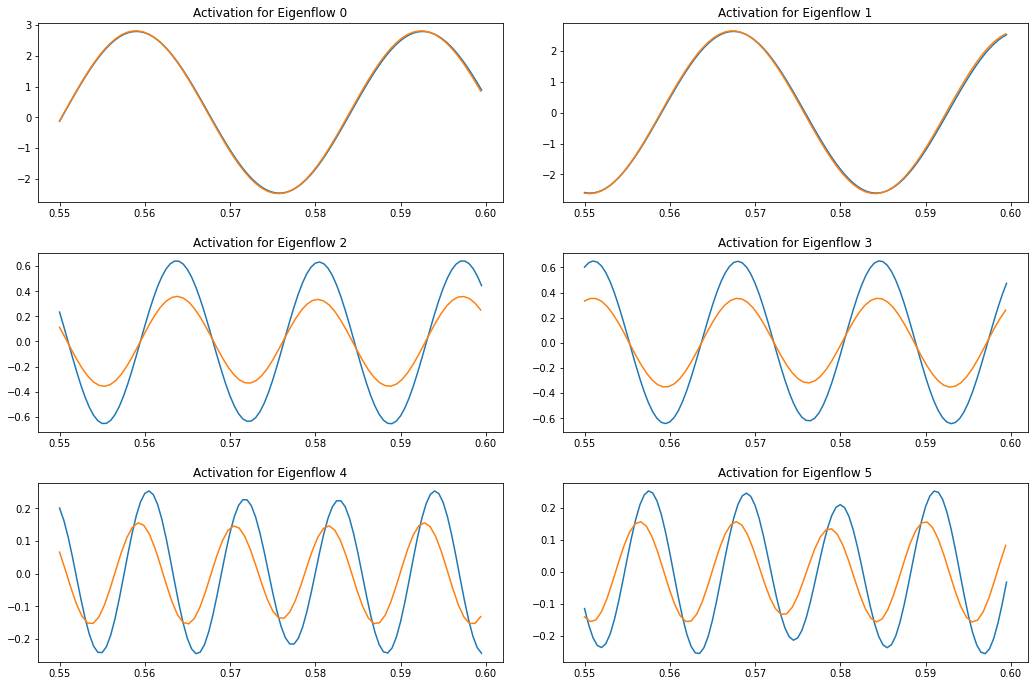

In [18]:
# Galerkin model 
d = int(num/2)
fig,ax = plt.subplots(d,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

t = sampling_span 
phase_shift = 74
plot_time_span = 100 * dt
orig_number = int(plot_time_span / (dt_ref*1.09))
t_orig = np.linspace(sampling_span[-100],tmax-dt_ref,num=orig_number)

# add plots over full time domain
for i in range(num):
    if num <= 2:
        ax[int(i%2)].plot(t[-100:],sol.y[i,-100:]/(sos * mach))
        ax[int(i%2)].plot(t_orig,coeffs[i,-(orig_number + phase_shift):-phase_shift]/(sos * mach))
        ax[int(i%2)].title.set_text("Activation for Eigenflow " + str(i))
    else:
        ax[int(i/2)][int(i%2)].plot(t[-100:],sol.y[i,-100:]/(sos * mach))
        ax[int(i/2)][int(i%2)].plot(t_orig,coeffs[i,-(orig_number + phase_shift):-phase_shift]/(sos * mach))
        ax[int(i/2)][int(i%2)].title.set_text("Activation for Eigenflow " + str(i))

# Reconstruction

In [19]:
# reconstruct flows
rec_len = 100
ssubsampling = int(shed_period / dt_ref / 20)
rec = np.repeat(np.expand_dims(q_avg,1),rec_len,1)
for i in range(num):
    rec += np.outer(pod_modes[:,i],sol.y[i,-100*ssubsampling::ssubsampling])

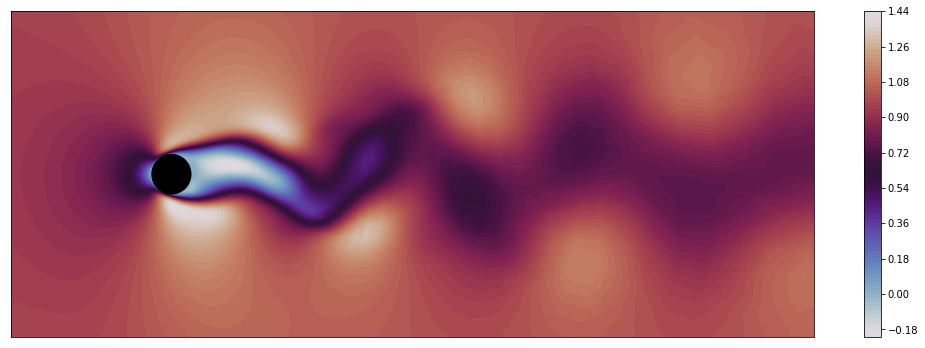

In [20]:
for i in range(100):
    data = rec[0*n:1*n,i]/(sos * mach)
    data[0] = q[:n,0].max()/(sos * mach) * 1.8
    data[1] = q[:n,0].min()/(sos * mach)
    plot_cylinder_data(x,y,data,zoom=True,cmap='twilight')
    #fac = int(0.03 / (0.0001 * subsampling) / 20)
    #plot_cylinder_data(x,y,q[0*n:1*n,i*fac]/(sos * mach), zoom=True, cmap='twilight')
    #plt.savefig(str(i)+".png")
    #plt.close('all')
    break

# Optimal Control - Controlled System Dynamics

Optimierung Peraire:
- $\gamma(\beta_m)$ 
- $a(\gamma)$ bestimmen
- $\phi_k$ über zusätzliche ODE lösen
- Gradientenfunktion( $a_k,\gamma,\phi_k$ ) bestimmen
- Update $\beta_k$

# Automatic Differentiation
- Parametrize Gamma -> $\beta_m$
- Declare $\beta_m$ as design variables
- Optimizationcycle for t -> $T_{Cal}$:
    1. Compute control input $\gamma(\beta)$
    2. Compute Galerkin activations $a(\gamma)$
    3. Compute cost function $J(a,\gamma)$
    4. Retrieve $\nabla_{\beta_m}J$ with AD
    5. Update $\beta_m$ with Gradient

In [21]:
# Optimization Parameters
design_dim = 8                                                             # number of design parameters

# Temporal Setup
t0 = 0                                                                      # starting time for optimization
tmax = shed_period * 20                                                     # end time for optimization -> 20 shedding periods
T = shed_period                                                             # shedding period
Nt = int(tmax/dt)                                                           # floored number of timesteps
sampling_span = np.linspace(t0,tmax-dt,num=int(tmax/dt))                    # optimization time span

# initial conditions
a0 = coeffs[:num,0]                                                         # initial activations
gamma_start = 0                                                             # initial control
gamma_max = 100                                                             # maximum allowable control

# criteria
epsilon = 1e-4                                                              # discontinuation criteria

In [23]:
# parameterized control function
def gamma(Nt,t0,tmax,dt,T,design_vars): 
    # empty control and control deriv arrays
    control = [0.0 for i in range(Nt)]
    control_deriv = [0.0 for i in range(Nt)]
    # loop timesteps
    for i in range(Nt):
        t = t0 + dt * i
        # loop design vars
        for j in range(design_dim): 
            control[i] = control[i] + design_vars[j] * np.sin(j * np.pi * t / (T * 2))
            control_deriv[i] = control_deriv[i] + design_vars[j] * np.cos(j * np.pi * t / (T * 2)) * j * np.pi / (T * 2)
    
        control[i] = control[i] + gamma_start * (1 - t / tmax)
        control_deriv[i] = control_deriv[i] - gamma_start * (1 / tmax)
    
    # return control and control derivative 
    return control, control_deriv 

def costFunction(a,gamma):
    cost = 0
    for i in range(num):
        cost = np.sum(np.sum(np.square(a),0) + np.exp(np.square(gamma) - np.square(gamma_max)) * dt)
    return cost

# Galerkin system
def galerkinSystem(t,a,gamma,dgamma):
    a_dot = np.empty_like(a)
    # iterate dof
    for k in range(a.shape[0]):
        a_dot[k] = nu * b1[k] + b2[k] + np.inner((nu * L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1)) + gamma * (nu * d1[k] + d2[k] + np.inner(g[k],a) + gamma * f[k]) + h[k] * dgamma
    # return activation derivative
    return a_dot

def solver(f,control_function,design_vars,interval,t0,y0,T,dt=dt):
    t0 = interval[0]
    tmax = interval[1]
    Nt = int(tmax/dt)
    control, control_deriv = control_function(Nt*2,t0,tmax,dt/2,T,design_vars)
    t = t0
    y_vec = np.zeros((num,Nt))
    y_vec[:,0] = y0
    for i in range(Nt-1):
        y = y_vec[:,i]
        k1 = dt * f(t,y,control[2*i],control_deriv[2*i])
        k2 = dt * f(t+dt/2,y+k1/2,control[2*i+1],control_deriv[2*i+1])
        k3 = dt * f(t+dt/2,y+k2/2,control[2*i+1],control_deriv[2*i+1])
        k4 = dt * f(t+dt,y+k3,control[2*i+2],control_deriv[2*i+2])
        k = (k1+2*k2+2*k3+k4)/6
        y_vec[:,i+1] = y_vec[:,i] + k
        t = t + dt  
    return y_vec

def costateProblem(t,phi,a,gamma):
    phi_dot = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        A = np.zeros(a.shape[0])
        for i in range(a.shape[0]):
            tmp = 0
            for j in range(a.shape[0]):
                tmp += (Q_[k][i,j] + Q_[k][j,i]) * a[j]
            A[i] = - (nu * L1[k][i] + L2[k][i] + tmp + g[k,i] * gamma)
        phi_dot[k] = np.inner(A,phi) - 0.5 * a[k]
    return phi_dot

def coStateSolver(f,control_function,design_vars,interval,t0,y0,T,dt=dt):
    t0 = interval[0]
    tmax = interval[1]
    Nt = int(tmax/dt)
    control, control_deriv = control_function(Nt*2,t0,tmax,dt/2,T,design_vars)
    t = t0
    y_vec = np.zeros((num,Nt))
    y_vec[:,0] = y0
    for i in range(Nt-1):
        y = y_vec[:,i]
        k1 = dt * f(t,y,control[2*i],control_deriv[2*i])
        k2 = dt * f(t+dt/2,y+k1/2,control[2*i+1],control_deriv[2*i+1])
        k3 = dt * f(t+dt/2,y+k2/2,control[2*i+1],control_deriv[2*i+1])
        k4 = dt * f(t+dt,y+k3,control[2*i+2],control_deriv[2*i+2])
        k = (k1+2*k2+2*k3+k4)/6
        y_vec[:,i+1] = y_vec[:,i] + k
        t = t + dt  
    return y_vec


In [24]:
# Optimization Loop for continuous adjoint
tmp = 1
cost = 0
counter = 0
maxIter = 10
alpha = 0.001
interval = [t0,tmax]
design_dim = 10
design_vars = np.ones(design_dim)
while(abs(cost) - abs(tmp) < epsilon):
    # max iteration loop break
    if counter > maxIter:
        break
    # copy previous cost
    tmp = cost
    # compute activations and control in solver
    Nt = int(tmax/dt)
    a_gal = solver(galerkinSystem,gamma,design_vars,interval,t0,a0,T,dt=dt)
    control, _ = gamma(Nt,t0,tmax,dt,T,design_vars)
    # computing helper functions in additional problem
    
    cost = costFunction(a_gal,control)
    break


In [93]:
def solver(f,interval,y0,dt=dt):
    # RK45 Solver -> trajectory of y
    t = interval[0]
    tmax = interval[1]
    Nt = int((tmax-t)/dt)
    alt = False
    if Nt < 0:
        Nt *= -1
        dt *= -1
        alt = True
    y = np.zeros((y0.shape[0],Nt))
    y[:,0] = y0
    for i in range(Nt-1):
        k1 = dt * f(t,y[:,i])
        k2 = dt * f(t+dt/2,y[:,i]+k1/2)
        k3 = dt * f(t+dt/2,y[:,i]+k2/2)
        k4 = dt * f(t+dt,y[:,i]+k3)
        k = (k1+2*k2+2*k3+k4)/6
        y[:,i+1] = y[:,i] + k
        t = t + dt  
    if alt:
        return np.flip(y,1)
    else:
        return y

# control function -> only time dependent
def gamma(t,T=T,gamma0=0):
    global design_vars
    tmp = gamma0 * (1 - t / T)
    for m in range(len(design_vars)):
        tmp += design_vars[m] * np.sin(m * np.pi * t *0.5 / T)
    return tmp

def gammaDerivative(t,T=T,gamma0=0):
    global design_vars
    tmp = - gamma0 * (1 / T)
    for m in range(len(design_vars)):
        tmp += design_vars[m] * np.cos(m * np.pi * t *0.5 / T) * m * np.pi * 0.5 / T
    return tmp

# helping function
def activation(t,dt=dt):
    global a
    try:
        if t % dt != 0:
            return 0.5 * (a[:,int(np.ceil(t/dt))] + a[:,int(np.floor(t/dt))])
        else:
            return a[:,int(t/dt)]
    except:
        return a[:,-1]
    

def control(dt,interval=interval,designVars=design_vars,gamma0=0):
    t0 = interval[0]
    tmax = interval[1]  
    Nt = int((tmax-t0)/dt)
    tmp = np.zeros(Nt)
    for i in range(Nt):
        tmp[i] = gamma0 * (1 - (t0 + i * dt) / T)
        for m in range(len(design_vars)):
            tmp[i] += design_vars[m] * np.sin(m * np.pi * (t0 + i * dt) * 0.5 / T) 
    return tmp
    
# ODE system dynamics
def costateProblem(t,phi,activation=activation,gamma=gamma):
    phi_dot = np.zeros_like(phi)
    a = activation(t)
    for k in range(phi.shape[0]):
        A = np.zeros(a.shape[0])
        for i in range(a.shape[0]):
            tmp = 0
            for j in range(a.shape[0]):
                tmp += (Q_[k][i,j] + Q_[k][j,i]) * a[j]
            A[i] = - (nu * L1[k][i] + L2[k][i] + tmp + g[k,i] * gamma(t))
        phi_dot[k] = np.inner(A,phi) - 0.5 * a[k]
    return phi_dot

def galerkinSystem(t,a,gamma=gamma,dgamma=gammaDerivative):
    a_dot = np.empty_like(a)
    control = gamma(t)
    controlDerivative = dgamma(t)
    # iterate dof
    for k in range(a.shape[0]):
        a_dot[k] = nu * b1[k] + b2[k] + np.inner((nu * L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1)) + control * (nu * d1[k] + d2[k] + np.inner(g[k],a) + control * f[k]) + h[k] * controlDerivative
    # return activation derivative
    return a_dot

def gradientFunction(phi,interval,dt):
    gradient = np.zeros(phi.shape[0])
    t0 = interval[0]
    tmax = interval[1]  
    Nt = int((tmax-t0)/dt)
    # gradient computation loop
    for m in range(phi.shape[0]):
        for n in range(Nt):    
            tmp_time = 0
            for k in range(num):
                # computing vector based A matrix
                A = np.zeros(a.shape[0])
                for i in range(a.shape[0]):
                    tmp = 0
                    for j in range(a.shape[0]):
                        tmp += (Q_[k][i,j] + Q_[k][j,i]) * a[j,n]
                    A[i] = - (nu * L1[k][i] + L2[k][i] + tmp + g[k][i] * gamma(t0 + n *dt))
                tmp = 0
                for i in range(num):
                    tmp  += h[k] * A[i] * phi[i,n] + g[k][i] * a[i,n]
                tmp_time += (tmp + nu * d1[k] + d2[k] + 2 * gamma(t0 + n * dt) * f[k]) * phi[k][n] + h[k] * 0.5 * a[k][n]
            gradient[m] += (tmp_time + np.exp(np.power(10*gamma(t0 + n * dt),2) - np.power(gamma_max,2)) * 2 * gamma(t0 + n * dt)) * np.sin(m * np.pi * n * dt * 0.5 / T)
    gradient *= dt
    return gradient

def costateCost(a,control,phi,max_control=100):
    cost = 0
    for i in range(num):
        cost += np.sum(np.sum(np.square(a),0) + np.exp(np.square(control) - np.square(max_control)) * dt)
    return cost 


In [94]:
# Optimization Loop for continuous adjoint
tmp = 1
cost = 0
counter = 0
maxIter = 10
alpha = 0.01
interval = [t0,tmax]
design_dim = 10
design_vars = np.ones(design_dim)
phi0 = np.zeros(num) 
while(abs(cost) - abs(tmp) < epsilon):
    # max iteration loop break
    if counter > maxIter:
        break
    # copy previous cost
    tmp = cost
    # compute control -> based on design variables
    con = control(dt=dt,interval=interval,designVars=design_vars)
    # compute activations -> control
    a = solver(galerkinSystem,interval,a0,dt=dt)
    # computing costate ode dynamics
    reversedInterval = [tmax,t0] 
    phi = solver(costateProblem,reversedInterval,phi0,dt=dt)
    # compute cost function 
    test = gradientFunction(phi,interval,dt)
    #cost = costFunction(a,control)
    
    break